In [1]:
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
from sklearn.decomposition import NMF
from random import random
import matplotlib.pyplot as plt
import boruta
import process_data
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

In [2]:
my_data=process_data.process('all_data.csv')

### XGboost & shap values

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=0)
XGBoost=GradientBoostingClassifier(n_estimators=100)
XGBoost=XGBoost.fit(X_train,y_train)

NameError: name 'X' is not defined

In [ ]:
y_pred=XGBoost.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred_train=XGBoost.predict(X_train)
print('accuracy ',accuracy_score(y_pred=y_pred_train,y_true=y_train))

accuracy  1.0


In [ ]:
from sklearn.metrics import accuracy_score
print('accuracy ',accuracy_score(y_pred=y_pred,y_true=y_test))

accuracy  0.56


In [ ]:
import shap
#shap values
# Fits the explainer
explainer = shap.TreeExplainer(XGBoost)
# Evaluate SHAP values
shap_values = explainer.shap_values(X)

ModuleNotFoundError: No module named 'shap'

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


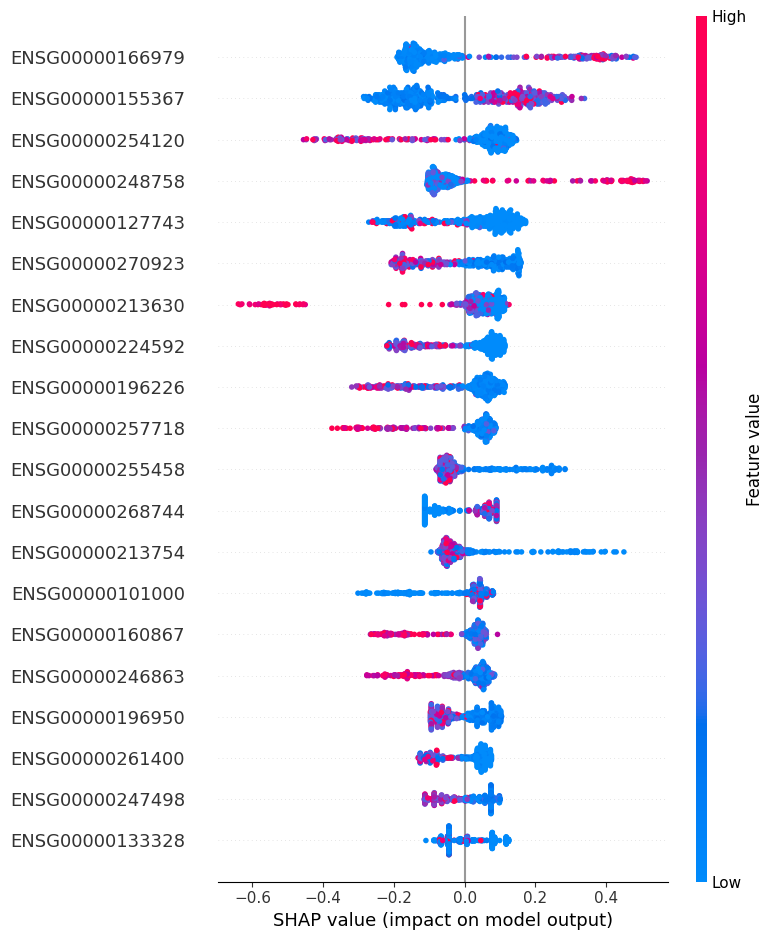

In [ ]:
shap.summary_plot(shap_values,X)

In [ ]:
feature_names=X.columns
top_n = 100
abs_shap_values = np.abs(shap_values.mean(axis=0))
top_n_idx = np.argsort(abs_shap_values)[-top_n:]
top_n_features = [feature_names[i] for i in top_n_idx]

print("Top %d features: %s" % (top_n, top_n_features))


In [ ]:
top_n_features = [feature_names[i] for i in top_n_idx]

In [ ]:
top_n_features

['ENSG00000155367',
 'ENSG00000269089',
 'ENSG00000152133',
 'ENSG00000206898',
 'ENSG00000189091']

### Feature selection 

In [31]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoLars, LassoCV, LassoLarsCV, LogisticRegression
from sklearn.svm import LinearSVC, SVC

#### SVM with linear kernel

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X,y=process_data.split_x_y(my_data)
X_train,X_test,y_train, y_test =train_test_split(X,y,test_size=0.1)

In [33]:
lsvc=LogisticRegression().fit(X_train,y_train)

/home/syrine/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
print(accuracy_score(lsvc.predict(X_test),y_test))

0.66


In [27]:
len(X_test)

50

In [29]:
len(y_test[y_test==1])

23

In [ ]:
importance=np.abs(lsvc.coef_).flatten()
feature_names=np.array(X.columns)

<Figure size 4000x15000 with 0 Axes>

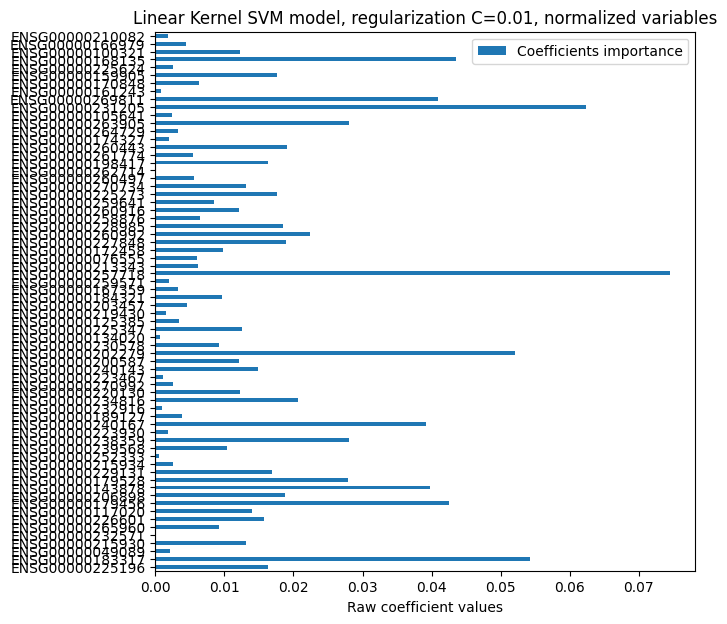

In [ ]:
coefs = pd.DataFrame(
    importance[importance!=0],
    columns=["Coefficients importance"],
    index=feature_names[importance!=0],
)

plt.figure(figsize=(40,150))
coefs.plot.barh(figsize=(9, 7))
plt.title("Linear Kernel SVM model, regularization C=0.01, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [ ]:
gene_list_svc=np.where([importance!=0])[1]

In [ ]:
features_svc=feature_names[gene_list_svc]

#### Lasso linear model

In [4]:
X,y=process_data.split_x_y(my_data)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train,X_test,y_train, y_test =train_test_split(X,y,test_size=0.1)

In [9]:
lasso=Lasso(alpha=0.11)

In [10]:
lasso.fit(X_train,y_train)

/home/syrine/.local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+00, tolerance: 1.102e-02
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.11)

In [11]:
print(accuracy_score(lasso.predict(X_test),y_test))

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [ ]:
def feature_selection(model,data,scaling):
    model_name=model[0]
    model_=model[1]
    X,y=process_data.split_x_y(data)
    feature_names=np.array(X.columns)
    if (scaling=='Standard'):
        X=StandardScaler().fit_transform(X)
    elif (scaling=='Max'):
        X=MaxAbsScaler().fit_transform(X)
    model_=model_.fit(X,y)
    importance=np.abs(model_.coef_)
    selected_coefs = pd.DataFrame(
    importance[importance!=0],
    columns=["Coefficients importance"],
    index=feature_names[importance!=0],
    )
    selected_coefs.plot.barh(figsize=(9, 7))
    plt.title(model_name+" model")
    plt.xlabel("Raw coefficient values")
    plt.axvline(x=0, color=".5")
    plt.subplots_adjust(left=0.3)
    selected_genes=list(selected_coefs.index)
    return selected_genes

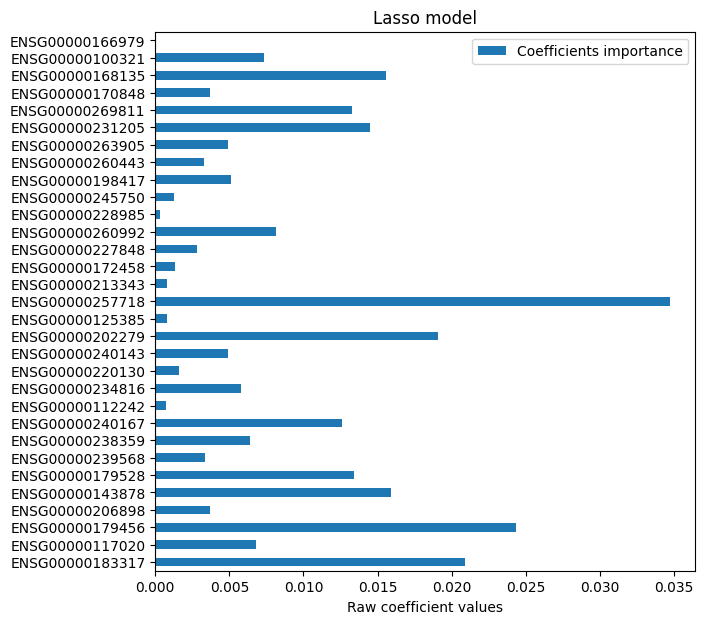

In [ ]:
selected=feature_selection(model=('Lasso',LassoCV(alphas=np.linspace(0.06,0.07,10))),data=my_data,scaling='Standard')

In [ ]:
data_reduced=pd.concat([my_data[selected],my_data['MRD Response']],axis=1)

In [ ]:
data_reduced

,ENSG00000183317,ENSG00000117020,ENSG00000179456,ENSG00000206898,ENSG00000143878,ENSG00000179528,ENSG00000239568,ENSG00000238359,ENSG00000240167,ENSG00000112242,...,ENSG00000198417,ENSG00000260443,ENSG00000263905,ENSG00000231205,ENSG00000269811,ENSG00000170848,ENSG00000168135,ENSG00000100321,ENSG00000166979,MRD Response
Patient_id,,,,,,,,,,,,,,,,,,,,,
165-06,12.925077,0.140193,4.597837,0.000000,1771.632500,0.594664,0.000000,0.532039,0.000000,7.452563,...,0.029292,3.816006,0.188847,0.015978,0.405859,0.183005,0.053590,3.178906,0.076268,0.0
031-31,2.047750,0.069093,0.192206,0.000000,2251.249538,1.098537,0.000000,0.000000,0.129630,5.829706,...,0.000000,0.510473,0.000000,0.000000,0.000000,0.036001,0.000000,0.063947,0.025506,1.0
069-02,2.660103,2.236593,4.957006,0.000000,190.839252,0.367059,0.000000,0.000000,0.386492,5.766801,...,0.496517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.297757,3.308024,1.0
007-08,3.605361,3.363103,3.171844,0.000000,1349.601203,0.588345,0.000000,0.000000,0.000000,11.197650,...,0.076074,0.991056,0.000000,0.010374,0.175676,0.125810,0.034795,3.176161,0.132050,0.0
034-24,2.021929,0.289308,2.569737,0.000000,703.515264,0.701240,0.000000,0.000000,0.000000,14.972768,...,0.141044,0.000000,0.000000,0.000000,0.465303,0.007405,0.000000,3.299234,0.008744,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147-11,0.066482,5.754683,19.789620,0.735268,416.465804,0.857186,0.000000,0.000000,0.603924,9.256157,...,0.078237,0.000000,0.000000,0.042677,0.602237,0.000000,0.000000,0.446878,0.022634,1.0
009-34,0.279484,0.275525,24.061104,0.000000,418.408851,0.081338,0.000000,0.000000,0.185564,3.839662,...,2.580210,0.000000,0.000000,0.000000,0.129532,0.000000,0.000000,0.732316,0.255582,0.0
104-22,0.618255,0.778411,2.366376,0.000000,211.465942,0.236410,0.252982,0.000000,0.220639,12.033758,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.891300,12.547102,1.447105,1.0


In [ ]:
import correlations_analysis

Le pourcentage de patients qui sont détectés MRD- est :  52.38095238095239 ,le nombre de patients dans le cluster est :  483
Le pourcentage de patients qui sont détectés MRD- est :  42.857142857142854 ,le nombre de patients dans le cluster est :  7
Le pourcentage de patients qui sont détectés MRD- est :  0.0 ,le nombre de patients dans le cluster est :  1


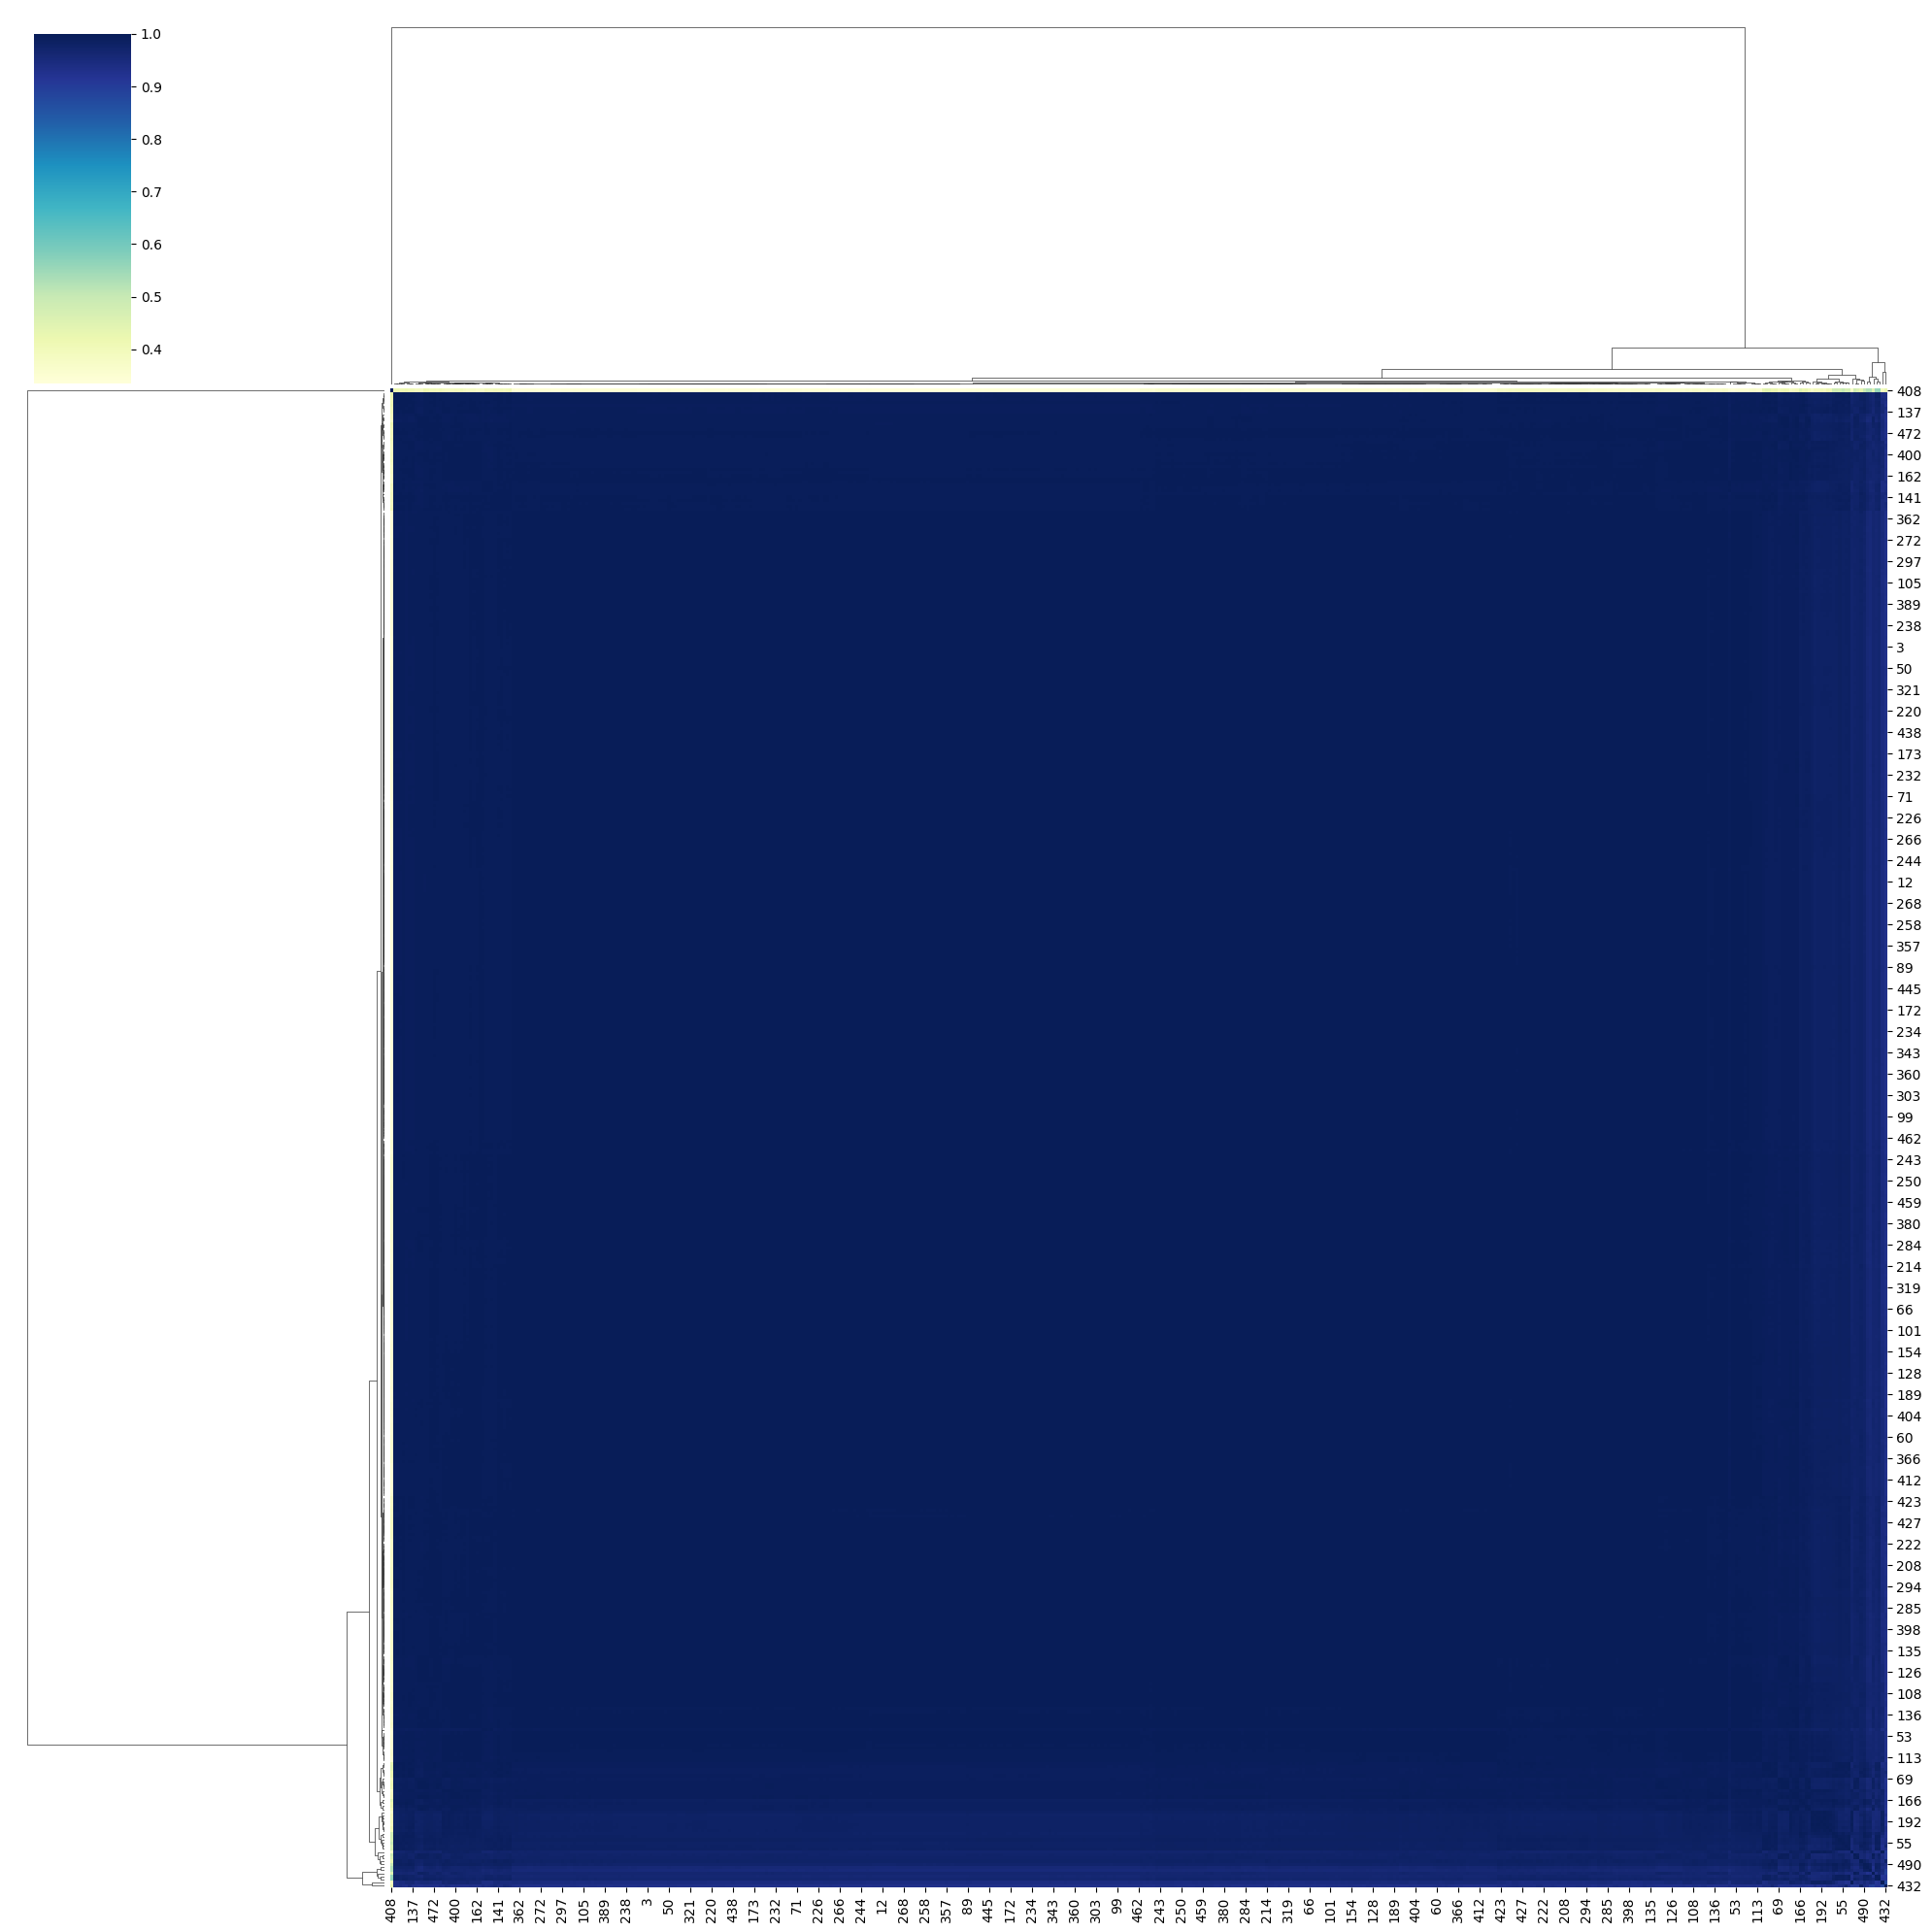

In [46]:
correlations_analysis.main(data_reduced,3)